# Mortality Rate Prediction Using Neural Networks

## 1. Introduction

The project will use past population data to predict future mortality rates for Australia. This is a regression type problem with log mortality rates $log(m_x)$ regressed against calendar year $t$ to forecast mortality rates. 

## 2. Data Preparation

### 2.1 Load packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

from scipy.linalg import svd
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Input, Embedding, Reshape, Dense, Concatenate
from tensorflow.keras.regularizers import l1

from sklearn.metrics import mean_absolute_error, mean_squared_error

### 2.2 Load data
The project uses the Australia population data set available on Human Mortality Databse (HMD) - labelled as "AUS".

Steps before importing csv into Python:
1. Download the data from website https://www.mortality.org/File/GetDocument/hmd.v6/AUS/STATS/Mx_1x1.txt -> RAW
2. Remove header rows -> EDITTED TXT
3. Open in Excel and convert to CSV using " " delimiter
4. Add headers back in

In [2]:
country = 'AUS'
gender = 'Male'

all_mort = pd.read_csv(f"{country}_mort.csv")

if (country == 'CHE'):
    all_mort.drop(columns = ['Country','imputed_flag','logmx'], inplace = True)
    all_mort = all_mort.pivot(index=['Year','Age'], columns='Gender')['mx'].reset_index()
    all_mort.columns.name = None
all_mort.head()


,Year,Age,Female,Male,Total
0,1921,0,0.059987,0.076533,0.068444
1,1921,1,0.012064,0.014339,0.013225
2,1921,2,0.005779,0.006047,0.005916
3,1921,3,0.002889,0.004197,0.003554
4,1921,4,0.003254,0.003254,0.003254


### 2.3 Data Formatting
- Replace "." with NA
- Encode age bracket "110+" as 110 - will be removed later on as we are investigating ages 0 to 99
- Converting age, mx and gender to int, float and category respectively

In [3]:
# make data wider to longer
all_mort = all_mort.melt(id_vars=['Year','Age'], value_vars =['Female','Male'], var_name = "Gender", value_name='mx')

#change 110+ to 110
all_mort.loc[all_mort['Age'] == '110+', 'Age'] = '110'

#replace . or 0 with NA
all_mort.loc[all_mort['mx'] == '.', 'mx'] = np.nan
all_mort.loc[all_mort['mx'] == 0, 'mx'] = np.nan

#convert type
all_mort['Gender'] = all_mort['Gender'].astype('category')
all_mort['Age'] = all_mort['Age'].astype('int')
all_mort['mx'] = all_mort['mx'].astype('float')
all_mort.dtypes

Year         int64
Age          int32
Gender    category
mx         float64
dtype: object

### 2.3 Data Pre-processing
Pre-processing steps were then applied so that the data is in the proper format for our models. This includes:
- Select calendar years t from 1950
- Select ages to be of values between 0 to 99 years
- Create *logmx* column which is the log of the mx column

In [4]:
#keep rows where year is within range and age is between 0 and 100
all_mort = all_mort[(all_mort['Year'] >= 1950) 
                    & (all_mort['Age'] >= 0) & (all_mort['Age'] < 100)
                    ]

#log mx
all_mort['logmx'] = np.log(all_mort['mx'])

After cleaning, there are no null values and all features are of expected type.

In [5]:
# check for null values
all_mort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14000 entries, 3219 to 21966
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Year    14000 non-null  int64   
 1   Age     14000 non-null  int32   
 2   Gender  14000 non-null  category
 3   mx      14000 non-null  float64 
 4   logmx   14000 non-null  float64 
dtypes: category(1), float64(2), int32(1), int64(1)
memory usage: 506.0 KB


Select gender to investigate - Female, Male or Total

In [6]:
gender_mort = all_mort[all_mort['Gender'] == gender].drop(columns = ['Gender'])

## 3. Data Exploration

The below heatmap illustrates the relationship between age x and the calendar year t. From the colour scale, red and blue represents low and high mortality rates respectively. 

We can observe the following patterns:
- Age effect: looking for vertical patterns in the heatmap, we can observe that in a given year, mortality rates tends to increase as age increases
- Period effect: looking for horizontal patterns in the heatmap, we can observe that for a given year, mortality rates tends to decrease as calendar year increases

Text(33.0, 0.5, 'Age x')

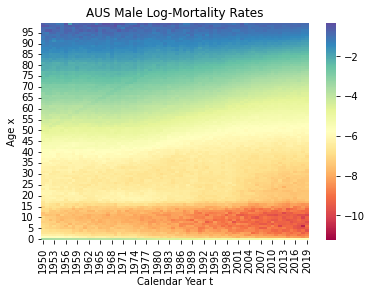

In [7]:
# find min value and max value to set the scale of the label to be consistent between male and female
minvalue = all_mort.logmx.min().min()
maxvalue = all_mort.logmx.max().max()

# pivot data to acceptable form for heatmap
plot_data = pd.pivot_table(gender_mort, values = 'logmx', index = 'Age', columns = 'Year')

# plot heatmap
heatmap = sns.heatmap(data = plot_data,vmin = minvalue, vmax = maxvalue, cmap = "Spectral").invert_yaxis()

# add title and labels
plt.title(f"{country} {gender} Log-Mortality Rates")
plt.xlabel('Calendar Year t')
plt.ylabel('Age x')

In the below plot of Log-Mortality Rates over calendar years, we can observe that as Year increases, the mortality rate does indeed decrease. 
Across all years, we can also observe that mortality in newborns and young infants is high but decreases upon survival. This then increases over teenage years to a peak in mid 20s before going into a trough and then gradual increase into the high mortality of the elderly.

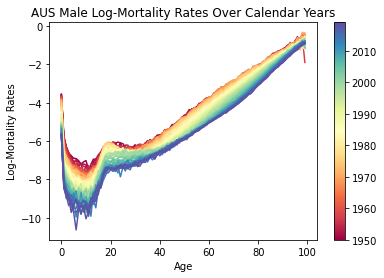

In [8]:
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=plot_data.columns.min(), vmax=plot_data.columns.max())
colormap = cm.Spectral

# plot
for n in plot_data.columns:
    plt.plot(plot_data[n], color=colormap(normalize(n)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(plot_data.columns)
plt.colorbar(scalarmappaple)

# add axis labs
plt.title(f"{country} {gender} Log-Mortality Rates Over Calendar Years")
plt.xlabel('Age')
plt.ylabel('Log-Mortality Rates')

# show the figure
plt.show()

In the below plot, we can observe that improvements in mortality over the past decades is more evident in younger ages - particularly of infants and children whereas those in older ages have experienced relatively less mortality improvements.

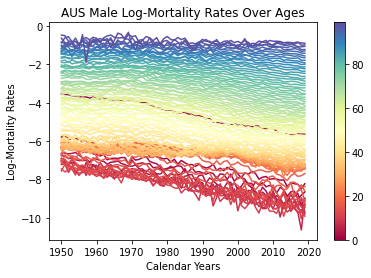

In [9]:
plot_data_t = plot_data.transpose()

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=plot_data_t.columns.min(), vmax=plot_data_t.columns.max())
colormap = cm.Spectral

# plot
for n in plot_data_t.columns:
    plt.plot(plot_data_t[n], color=colormap(normalize(n)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(plot_data_t.columns)
plt.colorbar(scalarmappaple)

# add axis labs
plt.title(f"{country} {gender} Log-Mortality Rates Over Ages")
plt.xlabel('Calendar Years')
plt.ylabel('Log-Mortality Rates')

# show the figure
plt.show()

## 4. Split into training, validation and test set

We then split the data into approximately 60% training, 20% validation and 20% test set, split by calendar year. The training set will contain only the observations prioer to the ones from the test set so that no future observations are used in constructing the forecast. This prevents any leaks that may cause a bias in estimation which leads to deviations in prediction error while applying the model to new unseen data.

In [27]:
# find year to split data at 
minYear = gender_mort.Year.min()
maxYear = gender_mort.Year.max()
interval = (maxYear - minYear)/10
traincut = int(minYear + interval * 6)
valcut = int(minYear + interval * 8)

# split data into train and test
train = gender_mort[gender_mort['Year'] < traincut]
val = gender_mort[(gender_mort['Year'] > traincut) & (gender_mort['Year'] < valcut)]
test = gender_mort[gender_mort['Year']> valcut]

train.Year.min(), val.Year.min(), test.Year.min()

(1950, 1992, 2006)

## 5. Baseline Model: Lee-Carter model

### 5.1 Parameter Estimation on testing Data
The Lee-Carter model is the most commonly used model for mortality forecast since its introduction in 1992 (**ADD CITATION**). It extrapolates trends and age patterns in mortality data to forecast future mortality rates.

Suppose we are considering ages x = 1,2,...,N and calendar years t = 1,2,...,T.

The model calculates the logarithm of the central death rate $log(m_{x,t})$ at age $x$ in the calendar year $t$ as:
$$log(m_{x,t}) = \mathbb{a}_x + b_x k_t + e_{x,t} \tag{$1$} $$
where:
- $m_{x,t}$ = observed central death rate at age x in year t
- $a_x$ = average age-specific pattern of mortality
- $b_x$ = age-specific patterns of mortality change as $k_t$ varies
- $k_t$ = time index describing mortality trend over time
- $e_{x,t}$ = error term which is assumed to be homoskedastic and with distribution $N~(0,\sigma_{\epsilon}^2)$

As such, the model explores much of the age, periodic and cohort patterns discussed in our exploratory analysis.

We will calculate the parameters from first principles. The model aims to find the least squares solution to equation 1. with the following procedure to estimate the parameters:

1. Set $\tilde{a}_x = \frac{\sum_{t=1}^T log(m_{x,t})}{T}$

In [11]:
a_x = train.groupby('Age')['logmx'].mean()

2. Center the raw log-mortality rates to get $\widetilde{M}_{x,t} = log(m_{x,t}) - \hat{a}_x$

In [12]:
train = train.assign(
    a_x = train.groupby(by = 'Age')['logmx'].transform('mean'), 
    mx_adj = lambda x: x['logmx'] - x['a_x']
)
rates_mat = pd.pivot_table(train, values = 'mx_adj', index = 'Age', columns = 'Year')

3. As Lee and Carter suggests, use Singular Value Decomposition of $\widetilde{M}_{x,t}$ where U, S and V represents the age component, singular values and time component respectively
$$\text{svd}(\widetilde{M}_{x,t}) = USV^T$$ 

In [13]:
u, s, vT = svd(rates_mat)

4. Solving this provides our estimates: $\tilde{b}_x = {U_{x1}}S_1$ and $\tilde{k_t} = V_{t1}$

In [14]:
b_x = u[:,0] * s[0]
k_t = vT.transpose()[:,0]

5. To ensure model identifiability (i.e. to obtain a unique solution), we then re-scale the estimates to satisfy the following constraints:
$\sum_x \hat{b}_x^2 = 1$ and $\sum_t \hat{k}_t = 0$

In [15]:
c1 = k_t.sum()
c2 = b_x.sum()
a_x = a_x + c1 * b_x
b_x = b_x / c2
k_t = (k_t - c1) * c2

Plots of our parameters reflect much of the observed trends in our exploratory data analysis.

Text(0.5, 1.0, 'k_t vs t')

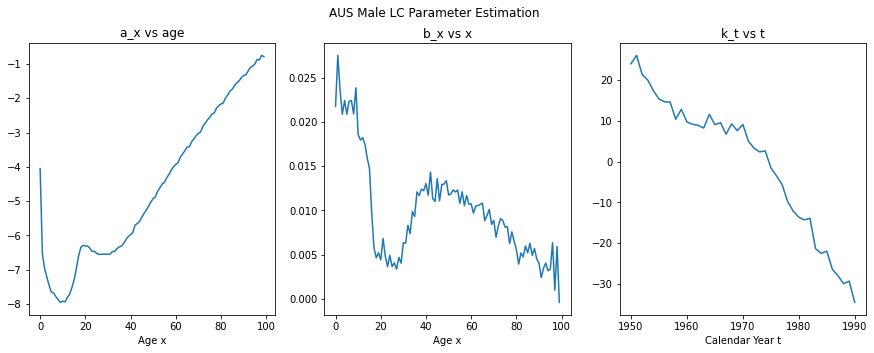

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

plt.suptitle(f"{country} {gender} LC Parameter Estimation")

ax1.plot(a_x)
ax1.set_xlabel('Age x')
ax1.set_title('a_x vs age')

ax2.plot(b_x)
ax2.set_xlabel('Age x')
ax2.set_title('b_x vs x')

ax3.plot(train.Year.unique(),k_t)
ax3.set_xlabel('Calendar Year t')
ax3.set_title('k_t vs t')

### 5.2 Forecast on Validation Data

As $a_x$ and $b_x$ are age-dependent rather than time-dependent, it is assumed they are constant over time. Hence, for our forecast, $k_t$ is the only parameter required to be extrapolated.

This is achieved through projection as a random walk with drift by modelling $k_t$ as an independent ARIMA(0,1,0) process.
$$k_t = k_{t-1} + \gamma + e_t$$
where $e_t ~ N(0,\sigma_\epsilon^2)$ and $\gamma$ is the drift

Text(0.5, 1.0, 'AUS Male Estimated Process k_t')

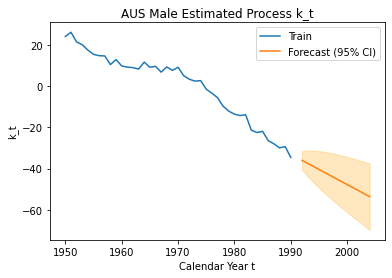

In [17]:
# fit ARIMA(0,1,0) to k_t
model = ARIMA(k_t, order=(0,1,0), trend = "t")
model_fit = model.fit()

# forecast k_t and confidence intervals
forecast = model_fit.get_forecast(steps=len(val.Year.unique()))
k_t_forecast = forecast.predicted_mean
k_t_forecast_ci = forecast.conf_int(alpha = 0.05)

# plot training and forecasted values
ax4 = plt.subplot(1,1,1)
ax4.plot(train.Year.unique(), k_t, label='Train')
ax4.plot(val.Year.unique(), k_t_forecast, label='Forecast (95% CI)')
ax4.fill_between(val.Year.unique(), k_t_forecast_ci[:,0], k_t_forecast_ci[:,1], color='orange', alpha=.25)
ax4.set_xlabel('Calendar Year t')
ax4.set_ylabel('k_t')
ax4.legend(loc='upper right')
ax4.set_title(f"{country} {gender} Estimated Process k_t")

### 5.3 Fit the model

On training data

In [18]:
# calculate log(mx) = ax + b_x * k_t
fitted_train = np.array([a_x]) + np.dot(np.array([k_t]).T, np.array([b_x]))

# change to dataframe 
fitted_train_df = pd.DataFrame(fitted_train)

# add column names
fitted_train_df.columns = train.Age.unique()

# add Year column
fitted_train_df['Year'] = train.Year.unique()

# melt the dataframe
fitted_train_dfmelt = fitted_train_df.melt(id_vars=['Year'], value_name='LC_pred_logmx', var_name='Age')

# calculate mx = exp(log(mx))
fitted_train_dfmelt['LC_pred_mx'] = fitted_train_dfmelt['LC_pred_logmx'].apply(lambda x: np.exp(x))

# merge train and fitted data
train_merge = pd.merge(train, fitted_train_dfmelt, on=['Year', 'Age'])

# drop a_x and mx_adj column
train_merge = train_merge.drop(columns=['a_x', 'mx_adj'])

# add residuals column
train_merge['residuals'] = train_merge['LC_pred_mx'] - train_merge['mx']


On validation data

In [19]:
# calculate log(mx) = ax + b_x * k_t
fitted_val = np.array([a_x]) + np.dot(np.array([k_t_forecast]).T, np.array([b_x]))

# change to dataframe 
fitted_val_df = pd.DataFrame(fitted_val)

# add column names
fitted_val_df.columns = val.Age.unique()

# add Year column
fitted_val_df['Year'] = val.Year.unique()

# melt the dataframe
fitted_val_dfmelt = fitted_val_df.melt(id_vars=['Year'], value_name='LC_pred_logmx', var_name='Age')

# calculate mx = exp(log(mx))
fitted_val_dfmelt['LC_pred_mx'] = fitted_val_dfmelt['LC_pred_logmx'].apply(lambda x: np.exp(x))

# merge train and fitted data
val_merge = pd.merge(val, fitted_val_dfmelt, on=['Year', 'Age'])

# add residuals column
val_merge['residuals'] = val_merge['LC_pred_mx'] - val_merge['mx']

### 5.3 Model Assessment

Plots of prediction performance reveal that 

Text(0.5, 1.0, 'Training Set Residuals')

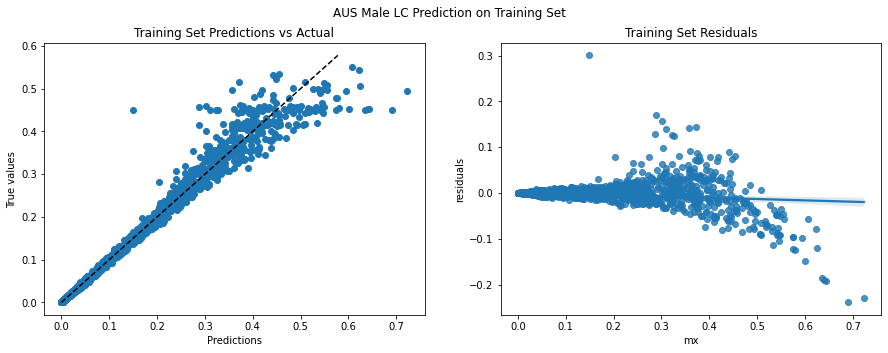

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

plt.suptitle(f"{country} {gender} LC Prediction on Training Set")

ax1.scatter(train_merge['mx'], train_merge['LC_pred_mx'])
ax1.set_xlabel("Predictions")
ax1.set_ylabel("True values")
ax1.set_title("Training Set Predictions vs Actual")

xl = ax1.get_xlim()
yl = ax1.get_ylim()
shortestSide = min(xl[1], yl[1])
ax1.plot([0, shortestSide], [0, shortestSide], color="black", linestyle="--")

sns.regplot(x = train_merge['mx'], y = train_merge['residuals'], data = None, scatter = True, ax=ax2)
ax2.set_title("Training Set Residuals")

Text(0.5, 1.0, 'Validation Set Residuals')

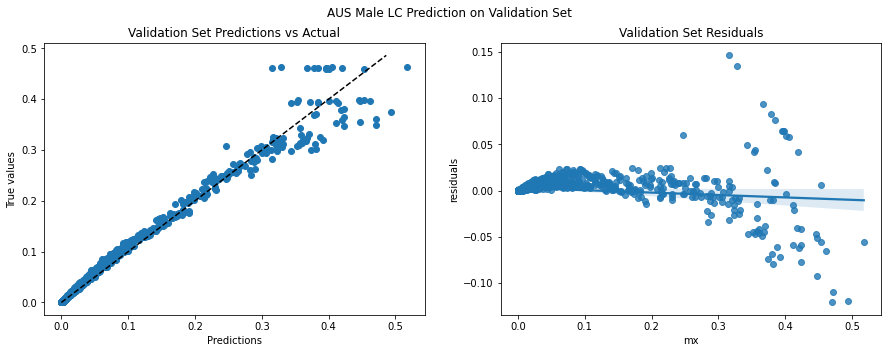

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

plt.suptitle(f"{country} {gender} LC Prediction on Validation Set")


ax1.scatter(val_merge['mx'], val_merge['LC_pred_mx'])
ax1.set_xlabel("Predictions")
ax1.set_ylabel("True values")
ax1.set_title("Validation Set Predictions vs Actual")

xl = ax1.get_xlim()
yl = ax1.get_ylim()
shortestSide = min(xl[1], yl[1])
ax1.plot([0, shortestSide], [0, shortestSide], color="black", linestyle="--")


sns.regplot(x = val_merge['mx'], y = val_merge['residuals'], data = None, scatter = True, ax=ax2)
ax2.set_title("Validation Set Residuals")

Calculation of MSE

The mean squared error was then calculated between the Lee Carter model's estimates of $m_x$ and the raw data's $m_x$. This serves as the baseline for our neural networks to beat.

In [22]:
mseLCTrain = mean_squared_error(train_merge['mx'], train_merge['LC_pred_mx'])
mseLCVal = mean_squared_error(val_merge['mx'], val_merge['LC_pred_mx'])

mseTrain = {"Lee Carter": mseLCTrain}
mseVal = {"Lee Carter": mseLCVal}

In [23]:
trainResults = pd.DataFrame({
    "Model": mseTrain.keys(), "MSE": mseTrain.values()
})
trainResults.sort_values("MSE", ascending=False)

,Model,MSE
0,Lee Carter,0.000287


In [24]:
valResults = pd.DataFrame({
    "Model": mseVal.keys(), "MSE": mseVal.values()
})
valResults.sort_values("MSE", ascending=False)

,Model,MSE
0,Lee Carter,0.000208


## 6. Deep Learning Model 1:

## 7. Deep Learning Model 2:

## 8. Evaluation of Final Chosen Model on Test Data

### 8.1 Selection of Final Model

### 8.2 Model Evaluation of Selected Model on Test Data